# Recommendation System with MovieLens Dataset
Related datasets can be found here http://grouplens.org/datasets/movielens/


In [2]:
import os
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt

from scipy.sparse import csr_matrix

In [3]:
link = "https://files.grouplens.org/datasets/movielens/ml-100k.zip"

# download to ./data if not already downloaded
target = "data/ml-100k"
if not os.path.exists(target):
    os.system("wget " + link + " -P data")
    os.system(f"unzip {target}.zip -d data")
    os.system(f"rm {target}.zip")

In [6]:
items_path = "data/ml-100k/u.item"
ratings_path = "data/ml-100k/u.data"
users_path = "data/ml-100k/u.user"
genres_path = "data/ml-100k/u.genre"
occupation_path = "data/ml-100k/u.occupation"

genre_dict = {}
with open(genres_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        if line == "\n":
            break
        genre, id = line.strip().split("|")
        genre_dict[int(id)] = genre
        
print(genre_dict)

header = ["user_id", "item_id", "rating", "timestamp"]
items_df = pd.read_csv(items_path, sep="|", encoding="ISO-8859-1", header=None)

# rename columns
items_df.columns = ["item_id", "title", "release_date", "video_release_date", "imdb_url"] + [genre_dict[i] for i in range(19)]

items_df.head(5)

{0: 'unknown', 1: 'Action', 2: 'Adventure', 3: 'Animation', 4: "Children's", 5: 'Comedy', 6: 'Crime', 7: 'Documentary', 8: 'Drama', 9: 'Fantasy', 10: 'Film-Noir', 11: 'Horror', 12: 'Musical', 13: 'Mystery', 14: 'Romance', 15: 'Sci-Fi', 16: 'Thriller', 17: 'War', 18: 'Western'}


,item_id,title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


0       1995.0
1       1995.0
2       1995.0
3       1995.0
4       1995.0
         ...  
1677    1998.0
1678    1998.0
1679    1998.0
1680    1994.0
1681    1996.0
Name: 2, Length: 1682, dtype: float64


Text(0.5, 1.0, 'Release year counts')

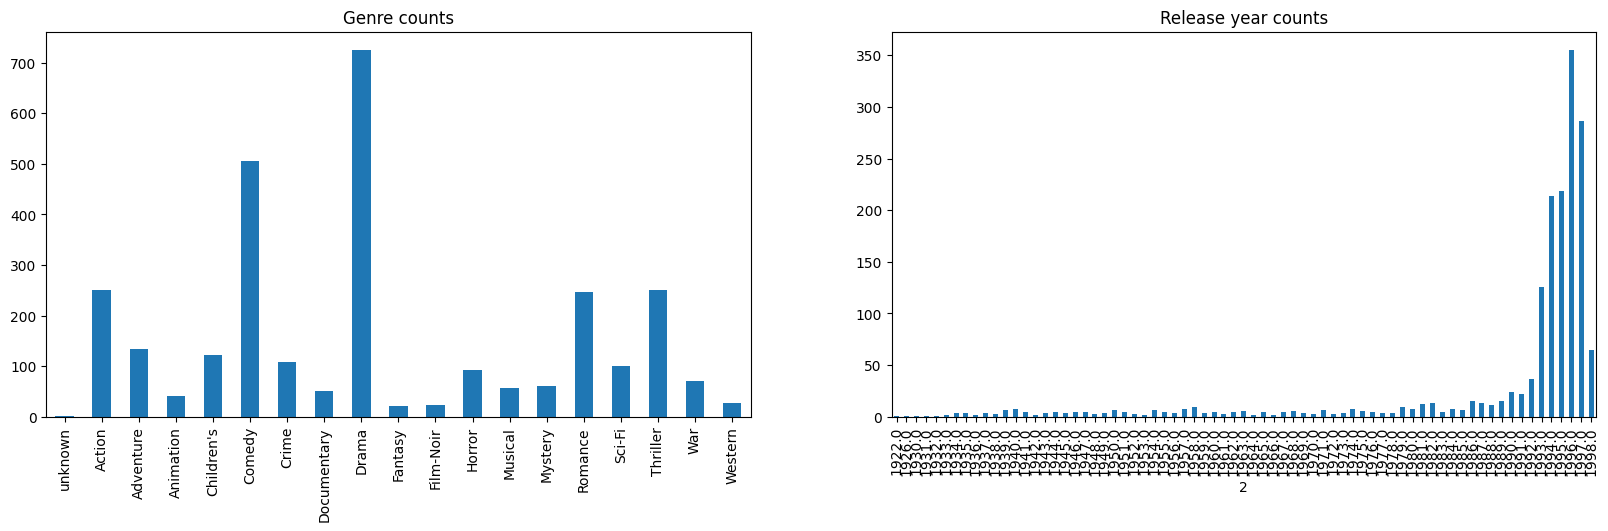

In [37]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 5))

# Graph genres counts and set genre names
genres = items_df.iloc[:, 5:].sum()
# Default ints are 5 to 24, so we need to add 5 to get the correct genre id
genres.index = [genre_dict[int(i)] for i in genres.index - 5]
genres.plot(kind="bar", ax=axes[0])
axes[0].set_title("Genre counts")

# Graph release year counts, from format 01-Jan-1995 to 1995, must be string, not float
release_years = items_df.iloc[:, 2]
release_years = release_years.apply(lambda x: datetime.strptime(str(x), "%d-%b-%Y").year if pd.notnull(x) else x)
release_years.value_counts().sort_index().plot(kind="bar", ax=axes[1])
axes[1].set_title("Release year counts")



In [7]:
ratings_df = pd.read_csv(ratings_path, sep="\t", header=None)
ratings_df.columns = ["user_id", "item_id", "rating", "timestamp"]

# Merge ratings with items, but only keep the title and genre columns
merged_df = ratings_df.merge(items_df[["item_id", "title"]], on="item_id")
merged_df.head(5)

In [42]:
unique_users = ratings_df["user_id"].nunique()
unique_movies = ratings_df["item_id"].nunique()

print(f"Unique users: {unique_users}")
print(f"Unique movies: {unique_movies}")

Unique users: 943
Unique movies: 1682


## Memory Based Collaborative Filtering

### User-Based CF

- train_df memory size: 35304.67 MB
- train_sparse memory size: 25.51 MB

Total memory usage: 23.51 MB
Sparsity: 0.99994117


### Item-Based CF